# Drilling Failure Prediction using Explainable Machine Learning

This project leverages synthetic drilling operation data to predict failure outcomes using machine learning. We focus on two key objectives:

1. **Binary classification** of overall drilling failure (`Main Failure`).
2. **Multi-label classification** of specific failure modes:
   - BEF: Build-up Edge Failure
   - CCF: Compression Chips Failure
   - FWF: Flank Wear Failure
   - WDF: Wrong Drill Bit Failure

We will also explore **Explainable AI (XAI)** techniques to interpret our model decisions using SHAP.


In [2]:
import pandas as pd

df = pd.read_csv("XAI_Drilling_Dataset.csv") 
df.head()


,ID,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Material,Drill Bit Type,Process Time [sec],Main Failure,BEF,CCF,FWF,WDF
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0
4,5,17.43,462,0.246,114,74.85,50,K,H,33.56,0,0,0,0,0


## Dataset Overview

Each row in the dataset represents one drilling operation. The input features include both numeric and categorical variables related to drilling parameters (e.g., speed, feed, power, material). The targets are the binary `Main Failure` and four binary failure mode flags.


In [3]:
print(f"Total rows: {df.shape[0]}, Total columns: {df.shape[1]}")
print("\nColumns:\n", df.columns.tolist())


Total rows: 20000, Total columns: 15

Columns:
 ['ID', 'Cutting speed vc [m/min]', 'Spindle speed n [1/min]', 'Feed f [mm/rev]', 'Feed rate vf [mm/min]', 'Power Pc [kW]', 'Cooling [%]', 'Material', 'Drill Bit Type', 'Process Time [sec]', 'Main Failure', 'BEF', 'CCF', 'FWF', 'WDF']


## Target Class Distribution

Before modeling, it is important to check if the dataset is balanced across the failure outcomes. We will examine:
- Overall failure rate (`Main Failure`)
- Distribution of individual failure modes (`BEF`, `CCF`, `FWF`, `WDF`)


In [4]:
# Binary target: Main Failure
main_failure_dist = df["Main Failure"].value_counts(normalize=True) * 100
print("Main Failure Distribution (%):")
print(main_failure_dist)

# Multi-label targets
print("\nFailure Mode Distributions (%):")
failure_modes = ["BEF", "CCF", "FWF", "WDF"]
for mode in failure_modes:
    pct = df[mode].value_counts(normalize=True).get(1, 0) * 100
    print(f"{mode}: {pct:.2f}% failure")


Main Failure Distribution (%):
Main Failure
0    94.995
1     5.005
Name: proportion, dtype: float64

Failure Mode Distributions (%):
BEF: 1.07% failure
CCF: 1.72% failure
FWF: 1.39% failure
WDF: 1.50% failure


## Class Imbalance Observations

The dataset is significantly imbalanced:

- **Only 5%** of records are labeled as `Main Failure = 1`.
- The specific failure modes are even rarer, each occurring in **~1–1.7%** of operations.

Such imbalance can cause ML models to be biased toward predicting the majority class (no failure). We'll address this using:
- **Resampling techniques** (SMOTE, under/oversampling)
- **Class weighting** in models
- **Evaluation metrics** appropriate for imbalance (e.g., F1, AUC, Precision-Recall)


In [5]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

df.dtypes


Missing values:
 Series([], dtype: int64)


ID                            int64
Cutting speed vc [m/min]    float64
Spindle speed n [1/min]       int64
Feed f [mm/rev]             float64
Feed rate vf [mm/min]         int64
Power Pc [kW]               float64
Cooling [%]                   int64
Material                     object
Drill Bit Type               object
Process Time [sec]          float64
Main Failure                  int64
BEF                           int64
CCF                           int64
FWF                           int64
WDF                           int64
dtype: object

## Categorical Features

We identified two categorical features:
- `Material`
- `Drill Bit Type`

These will need to be encoded before modeling. We'll use **one-hot encoding** to handle them efficiently.


In [6]:
# Drop ID column
df = df.drop(columns=["ID"])

# Display unique values in categorical columns
print("Unique values in 'Material':", df["Material"].unique())
print("Unique values in 'Drill Bit Type':", df["Drill Bit Type"].unique())


Unique values in 'Material': ['N' 'P' 'K']
Unique values in 'Drill Bit Type': ['W' 'N' 'H']


## One-Hot Encoding Categorical Features

We will apply one-hot encoding to convert:
- `Material`
- `Drill Bit Type`

into binary columns suitable for machine learning. We'll use `pd.get_dummies()` and drop the first category to avoid multicollinearity.


In [7]:
# Apply one-hot encoding to categorical columns
df_encoded = pd.get_dummies(df, columns=["Material", "Drill Bit Type"], drop_first=True)

# Display the updated columns to verify encoding
print("Encoded DataFrame Columns:")
print(df_encoded.columns.tolist())


Encoded DataFrame Columns:
['Cutting speed vc [m/min]', 'Spindle speed n [1/min]', 'Feed f [mm/rev]', 'Feed rate vf [mm/min]', 'Power Pc [kW]', 'Cooling [%]', 'Process Time [sec]', 'Main Failure', 'BEF', 'CCF', 'FWF', 'WDF', 'Material_N', 'Material_P', 'Drill Bit Type_N', 'Drill Bit Type_W']


## Check Ranges of Numerical Features

Before scaling, it's important to inspect the range and spread of each numerical feature. Features with vastly different scales (e.g., Power in kW vs Feed in mm/rev) can affect some algorithms (e.g., logistic regression, SVM).

Let’s examine the descriptive statistics.


In [8]:
# Exclude target and one-hot columns
target_cols = ["Main Failure", "BEF", "CCF", "FWF", "WDF"]
one_hot_cols = [col for col in df_encoded.columns if "Material_" in col or "Drill Bit Type_" in col]

# Get numeric input features
feature_cols = [col for col in df_encoded.columns if col not in target_cols + one_hot_cols]

# Show summary stats for numerical input features
df_encoded[feature_cols].describe()


,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Process Time [sec]
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,23.322470,618.644400,0.224831,140.629850,128.992781,56.750000,29.242184
std,5.174178,137.248701,0.037563,41.470466,65.403239,23.941933,6.866544
min,16.330000,433.000000,0.108000,62.000000,49.040000,0.000000,15.970000
25%,17.590000,467.000000,0.193000,109.000000,78.510000,50.000000,20.360000
50%,22.610000,600.000000,0.233000,122.000000,93.250000,50.000000,32.960000
75%,29.780000,790.000000,0.254000,183.000000,203.600000,75.000000,34.530000
max,31.070000,824.000000,0.321000,261.000000,305.220000,100.000000,38.570000


## Feature Scaling (Standardization)

We'll standardize all numeric input features to have:
- Mean = 0
- Standard Deviation = 1

This helps improve convergence and performance for many ML models.


In [9]:
from sklearn.preprocessing import StandardScaler

# Scale numerical feature columns
scaler = StandardScaler()
df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])

# Confirm scaling by checking mean/std
df_encoded[feature_cols].describe().loc[["mean", "std"]]


,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Process Time [sec]
mean,-8.242296e-17,-1.406875e-16,5.912604e-16,-1.087130e-16,-1.207923e-16,-1.705303e-17,2.650324e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00


# Step 3: Binary Classification - Predicting Main Failure

Our objective here is to build a model to classify whether a drilling operation results in a failure (`Main Failure = 1`) or not (`Main Failure = 0`).

We'll begin with:
- Splitting the dataset into training and test sets
- Using Logistic Regression with class weights to handle imbalance
- Evaluating using F1-score, AUC, and confusion matrix


In [10]:
from sklearn.model_selection import train_test_split

# Define input features and target
X = df_encoded.drop(columns=["Main Failure", "BEF", "CCF", "FWF", "WDF"])
y = df_encoded["Main Failure"]

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True) * 100}")


Training samples: 16000
Test samples: 4000
Target distribution in training set:
Main Failure
0    94.99375
1     5.00625
Name: proportion, dtype: float64


## Train Logistic Regression (with Class Weight)

We will:
- Train a logistic regression model
- Use `class_weight="balanced"` to compensate for rare failure cases
- Evaluate using classification report, AUC, and confusion matrix


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Train model
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0     0.9849    0.9600    0.9723      3800
           1     0.4865    0.7200    0.5806       200

    accuracy                         0.9480      4000
   macro avg     0.7357    0.8400    0.7765      4000
weighted avg     0.9600    0.9480    0.9527      4000


Confusion Matrix:
[[3648  152]
 [  56  144]]

ROC AUC Score: 0.8466631578947369


## Train XGBoost Classifier

We'll use XGBoost with `scale_pos_weight` to handle class imbalance. This weight is set to the ratio of negative to positive classes in the training data.

Steps:
- Train model using default XGBoost settings
- Evaluate with precision, recall, F1-score, and ROC AUC


In [14]:
import xgboost as xgb
from xgboost import XGBClassifier

# Clean column names in X_train and X_test
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Replace problematic characters
X_train_clean.columns = X_train_clean.columns.str.replace(r"[<>\[\] ]", "_", regex=True)
X_test_clean.columns = X_train_clean.columns  # Ensure same columns

# Update class imbalance ratio
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

# Train XGBoost model
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_clean, y_train)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
# Predict
y_pred_xgb = xgb_model.predict(X_test_clean)
y_proba_xgb = xgb_model.predict_proba(X_test_clean)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))


Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9987    0.9992      3800
           1     0.9755    0.9950    0.9851       200

    accuracy                         0.9985      4000
   macro avg     0.9876    0.9968    0.9922      4000
weighted avg     0.9985    0.9985    0.9985      4000


Confusion Matrix:
[[3795    5]
 [   1  199]]

ROC AUC Score: 0.9999328947368421


# Explain Model Predictions with SHAP

We’ll use SHAP (SHapley Additive exPlanations) to interpret the XGBoost model:
- Understand which features most influence the prediction of drilling failure.
- Visualize both **global importance** and **individual predictions**.

We use `TreeExplainer` for optimized performance with XGBoost.


In [17]:
non_numeric_cols = X_test_clean.select_dtypes(exclude=["number"]).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

Non-numeric columns: ['Material_N', 'Material_P', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']


In [21]:
# Convert all boolean columns to integers (0/1)
for df_ in [X_train_clean, X_test_clean]:
    bool_cols = df_.select_dtypes(include=["bool"]).columns
    df_[bool_cols] = df_[bool_cols].astype(int)

# Confirm final types
print("Remaining non-numeric columns:", X_test_clean.select_dtypes(exclude=["number"]).columns.tolist())


Remaining non-numeric columns: []


In [22]:
import shap
import matplotlib.pyplot as plt

# Initialize TreeExplainer with trained model
explainer = shap.Explainer(xgb_model, X_train_clean)
shap_values = explainer(X_test_clean)


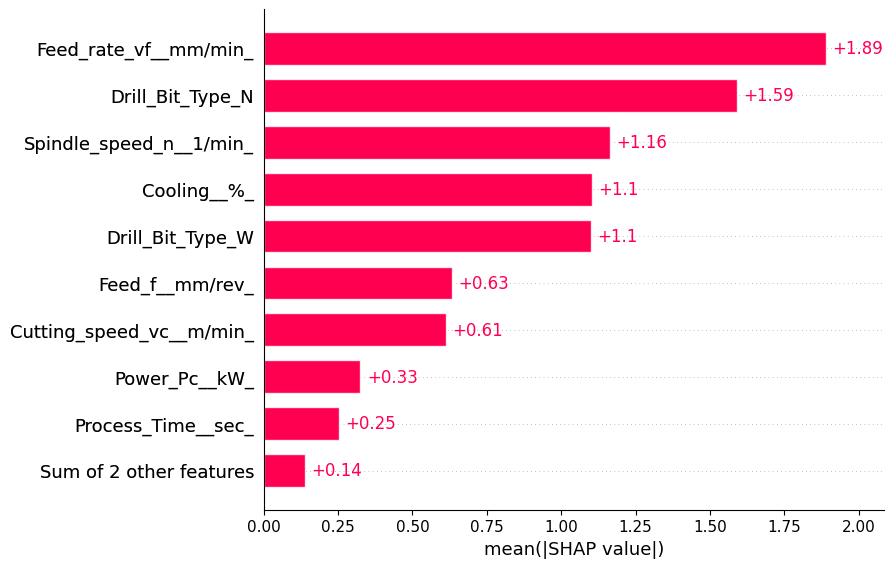

In [23]:
import matplotlib.pyplot as plt

shap.plots.bar(shap_values, max_display=10)


| Feature                   | SHAP Impact | Insight                                              |
| ------------------------- | ----------- | ---------------------------------------------------- |
| `Feed_rate_vf__mm/min_`   | **Highest** | High feed rates significantly increase failure risk. |
| `Drill_Bit_Type_N`        | High        | Certain drill bit types are more failure-prone.      |
| `Spindle_speed_n__1/min_` | Moderate    | Spindle speed also affects failure likelihood.       |
| `Cooling__%_`             | Moderate    | Insufficient cooling is a known failure driver.      |
| `Process_Time__sec_`      | Low         | Minor influence, may be a proxy for other factors.   |


In [25]:
# Get indices of test samples predicted as failure (1)
failure_indices = X_test_clean[y_pred_xgb == 1].index

sample_idx = failure_indices[0]
sample = X_test_clean.loc[sample_idx:sample_idx]


In [27]:
# Get all row positions where prediction == 1 (failure)
import numpy as np

failure_pos = np.where(y_pred_xgb == 1)[0]

# Pick the first such failure prediction
pos = failure_pos[0]

# Show the SHAP force plot for that row
shap.initjs()
shap.plots.force(shap_values[pos])


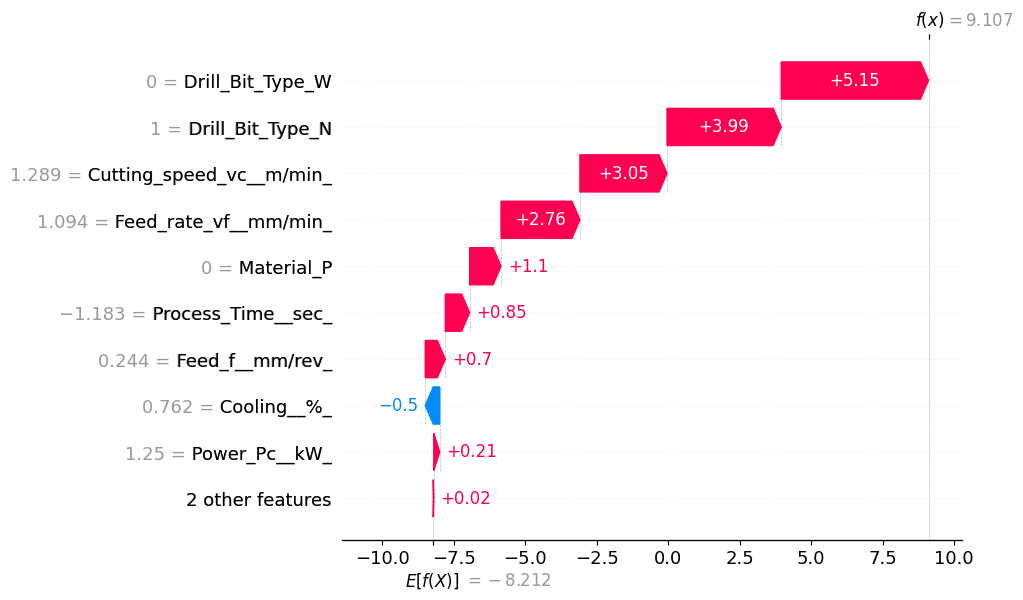

In [28]:
# Waterfall plot for the same failure case
shap.plots.waterfall(shap_values[pos], max_display=10)


# Multi-Label Classification – Predicting Failure Modes

We will build a model to predict specific failure modes:
- BEF (Build-up Edge Failure)
- CCF (Compression Chips Failure)
- FWF (Flank Wear Failure)
- WDF (Wrong Drill Bit Failure)

Each sample can have **0, 1, or more failure modes**, making this a multi-label problem.

We’ll use:
- A shared XGBoost classifier per label (One-vs-Rest strategy)
- `sklearn.multioutput.MultiOutputClassifier`


In [30]:
X_multi = df_encoded.drop(columns=["Main Failure"])
y_multi = df_encoded[["BEF", "CCF", "FWF", "WDF"]]

X_multi.columns = X_multi.columns.str.replace(r"[<>\[\] ]", "_", regex=True)

X_multi = X_multi.astype(float)

# Split
from sklearn.model_selection import train_test_split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42
)


In [31]:
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

multi_model = MultiOutputClassifier(
    XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=42
    )
)

multi_model.fit(X_train_m, y_train_m)


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [32]:
from sklearn.metrics import classification_report

y_pred_multi = multi_model.predict(X_test_m)

y_pred_multi_df = pd.DataFrame(y_pred_multi, columns=["BEF", "CCF", "FWF", "WDF"])

# Print classification report for each failure mode
for label in ["BEF", "CCF", "FWF", "WDF"]:
    print(f"--- {label} ---")
    print(classification_report(y_test_m[label], y_pred_multi_df[label], digits=4))


--- BEF ---
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3958
           1     1.0000    1.0000    1.0000        42

    accuracy                         1.0000      4000
   macro avg     1.0000    1.0000    1.0000      4000
weighted avg     1.0000    1.0000    1.0000      4000

--- CCF ---
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3923
           1     1.0000    1.0000    1.0000        77

    accuracy                         1.0000      4000
   macro avg     1.0000    1.0000    1.0000      4000
weighted avg     1.0000    1.0000    1.0000      4000

--- FWF ---
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3942
           1     1.0000    1.0000    1.0000        58

    accuracy                         1.0000      4000
   macro avg     1.0000    1.0000    1.0000      4000
weighted avg     1.0000    1.0000    1